<a href="https://colab.research.google.com/github/shreyamusini/Data-Analysis-On-Willet-Handwriting-Dataset/blob/main/Data_Analysis_of_the_Willet_Handwriting_Dataset_from_BCI_Workshop_Hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Packages
import os
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [114]:
# # Mount the Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
#Download Datasets
!gdown --folder https://drive.google.com/drive/folders/12zq88uHnHSAvadIkwF3NOl_XodihXrn5?usp=drive_link -O /content/Datasets

Retrieving folder list
Processing file 1Nc_5brAD2JxiLcdjDwTlnCwaSZ2HSgmf all_avg.csv
Processing file 19yH2XM55GSMF_2d_IrQKn3VmiOP9ZYHg all_data_192.csv
Processing file 1i3Lnwx923V67Y9-n8knwa-m1TLmUf6Ng all_data_192.npy
Processing file 13nJ9Dv2s3wbVRSKjQ94iI8n4XUutWyKL all_data_non_pca.csv
Processing file 1SgdDNpOQRcPpFi3NqbjMlGAYVpcV_4lc all_data.csv
Processing file 1FLsGm8k_9oVBTH13zzXGKzGQGRLdzwwS all_data.npy
Processing file 14xX3HxaKV8ODfVwPKwOWMDyiDpqPaFpy all_labels_new.csv
Processing file 1gInj09f72i7beaB6OVgB0d6u_oxhfTdp all_labels.csv
Processing file 13MTyjd__7WRRqXUupTHPfT1W5YJeus5h all_labels.npy
Processing file 1DadV4ppzfnwtMFR75uq6bs0vp09fphXG singleLetters.mat
Processing file 1f5t4UEM51GiAHErIfL9vSW2QnmvzJ5w4 t5.2019.05.08_warpedCubes.mat
Processing file 1uibR_8bX1FeY5_7BrzQdaZcc9gshdCFs X_transformed_best.npy
Processing file 13-gHr_bBBIr5KZmlAmZEd6-1rg-S6bYD X_transformed_new_1.npy
Processing file 1-2Ka0MpMVLc0HGcDTUtCNlPjR8sj7ZlN X_transformed_new.npy
Processing file 1W

In [4]:
# Initialize the paths
DPATH = "/content/Datasets"
os.chdir(DPATH)

In [105]:
data = np.load(os.path.join(DPATH, "all_data_192.npy"))
labels = pd.read_csv(os.path.join(DPATH, "all_labels_new.csv"), index_col=0)["labels"]
labels = labels.values

In [106]:
labels

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b', 'b',
       'b', 'b', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c',
       'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c', 'c',
       'c', 'c', 'c', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd',
       'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd',
       'd', 'd', 'd', 'd', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e',
       'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e', 'e',
       'e', 'e', 'e', 'e', 'e', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',
       'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f', 'f',
       'f', 'f', 'f', 'f', 'f', 'f', 'g', 'g', 'g', 'g', 'g', 'g', 'g',
       'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'g

Helper Functions from Willet Dataset Google Collab

In [7]:
def warping_distance_metric(x, y):
    """
    Warping distance metric to be used for t-SNE.
    Code adapted from Willet et al. 2021
    """
    timepoints_considered = 142
    neural_dims = y.size//timepoints_considered

    # Using the same linspace range as in the paper
    affine_wrap = np.linspace(0.7, 1.42, 15)

    # Reshape x like in MATLAB
    x = x.reshape(timepoints_considered, neural_dims, order="F")
    distance = np.zeros_like(affine_wrap)

    for idx, afw in enumerate(affine_wrap):
        # scipy interpolate structure:
        # actual x, actual y
        # locations were would would like to get the values
        interpolation = scipy.interpolate.interp1d(range(x.shape[0]), x, axis=0, kind="linear")
        x_interp = interpolation(np.linspace(0, x.shape[0]-1, int(x.shape[0]*afw)))

        # Reshape y like in MATLAB
        y = y.reshape(timepoints_considered, neural_dims, order="F")
        # Calculate the eucledian distance.
        # But only over the relevant time points.
        # If the affine warp value considered is over 1,
        # Then, we have to exclude the values that extend over timepoints_considered

        if afw > 1:
            diff = x_interp[:x.shape[0]] - y
        else:
            diff = x_interp - y[:x_interp.shape[0]]

        distance[idx] = np.linalg.norm(diff)
    return np.min(distance)

def plot_tsne_results(df):
    """
    Function to plot the t-SNE results
    """

    colors = [[0.3613, 0.8000,  0], [0.8000,  0, 0.1548], \
              [0.8000, 0.1548,  0], [0.8000,  0, 0.4645], \
              [0.6710,  0, 0.8000], [0.3613,  0, 0.8000], \
              [0.5161, 0.8000,  0], [0.8000, 0.6194,  0], \
              [0.8000,  0,  0], [0.6710, 0.8000,  0], \
              [0.2065,  0, 0.8000],  [0, 0.1032, 0.8000], \
              [0.8000, 0.3097,  0],  [0, 0.7226, 0.8000], \
              [0, 0.8000, 0.5677],  [0, 0.8000, 0.2581], \
              [0, 0.2581, 0.8000], [0.0516,  0, 0.8000], \
              [0.8000,  0, 0.6194], [0.8000, 0.4645,  0], \
              [0.8000,  0, 0.7742], [0.8000, 0.7742,  0], \
              [0, 0.5677, 0.8000], [0.8000,  0, 0.3097], \
              [0, 0.8000, 0.4129], [0.0516, 0.8000,  0], \
              [0, 0.4129, 0.8000], [0.5161,  0, 0.8000], \
              [0.2065, 0.8000,  0],  [0, 0.8000, 0.1032], \
              [0, 0.8000, 0.7226]]
    colors = np.array(colors)

    # Maping from the colors to the labels
    color_dict_mapping = {}
    unique_labels = ["a","b","c","d","e","f","g","h","i","j","k","l","m","n", \
                     "o","p","q","r","s","t","u","v","w","x","y","z",">","comma", \
                     "'","~","?"]
    for idx in range(len(unique_labels)):
        color_dict_mapping[unique_labels[idx]] = colors[idx, :]

    # Plot away
    ax = plt.axes()
    for idx,char in enumerate(unique_labels):
        ax.scatter(df[df["label"]==char]["x"], df[df["label"]==char]["y"], \
                   c=colors[idx], alpha=0.5, label=char, edgecolor="white")

    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", ncols=2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("t-SNE Distribution of the Characters based on Neural Data")
    ax.set_xlabel("")
    ax.set_ylabel("")
    label_points(ax, df, unique_labels)


def label_points(ax, df, unique_labels):
    a = pd.DataFrame()
    for i in unique_labels:
        a = pd.concat([a, pd.DataFrame({"x": [df[df["label"] == i]["x"].mean()], \
                      "y": [df[df["label"] == i]["y"].mean()], \
                      "val": [i]})], ignore_index=True)

    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

    plt.show()


def tsne_analysis(data, labels, distance_metric=warping_distance_metric):
    """
    Function to perform the t-SNE analysis (Figure 1e in thr paper).
    Given the input data, the function performs t-SNE dimensionality
    reduction on the data and plots the data in 2D space.

    Input:
        - data: Transformed neural data of dimensions (837, 2130) (i.e.)
                837 = 27*31 is from (number of trials (27) aross all characters (31)
                2130 = 142*15 is from (timepoints of interest after go cue (142), across all neural PC dimensions (15))
        - labels: Character label vector correposnding to the input datapoints of size 837
        - distance_metric: Metric to be used by t-SNE
    """
    # Check if t-SNE is already run for the data in question
    test_data = np.load(os.path.join(DPATH, "all_data_192.npy"))
    test_data = test_data.reshape((837, 142, 192), order='F')[:, :, :15]
    test_data = test_data.reshape((837, -1), order='F')
    print("Func:", test_data.shape)
    if np.all(np.isclose(test_data, data)):
        # In case the final output is already avaliable, use the
        # transformed data for the plot.
        # Note that the t-SNE function takes ~20 minutes to run when the
        # warping distance metric is used.
        if os.path.exists(os.path.join(DPATH, "X_transformed_best.npy")):
            X_transformed = np.load(os.path.join(DPATH, "X_transformed_best.npy"))
        else:
            print("Running t-SNE.\nNOTE: This will take a while (~20minutes)...")
            tsne = TSNE(n_components=2, perplexity=40, metric=distance_metric)
            X_transformed = tsne.fit_transform(data)
            np.save(os.path.join(DPATH, "X_transformed"), X_transformed)
    else:
        print("Running t-SNE.\nNOTE: This will take a while (~20minutes)...")
        tsne = TSNE(n_components=2, perplexity=40, metric=distance_metric)
        X_transformed = tsne.fit_transform(data)
        np.save(os.path.join(DPATH, "X_transformed"), X_transformed)


    df = pd.DataFrame()
    df["x"] = X_transformed[:, 0]
    df["y"] = X_transformed[:, 1]
    df["label"] = labels

    # Plot the results
    plot_tsne_results(df)

    return df

def plot_pc_data(data, labels, select_chars_idx=[3, 4, 11], num_chars=31, \
                 time_considered=142, num_repeats=27, n_dims=3):
    """
    Visualize the top 3 PCs, given the index of the characters.
    """
    viz_data = data.copy()
    viz_data = data.reshape((837, 142, 192), order='F')
    viz_data = viz_data[:, :, :3]

    avg_data_all = np.zeros((num_chars, time_considered, n_dims))

    # Select a small subset of characters to plot
    for i in select_chars_idx:
        char_data = viz_data[i*num_repeats:(i+1)*num_repeats]
        avg_data_all[i] = char_data.mean(axis=0)

        plt.figure(figsize=(18, 3))
        plt.subplot(1, 3, 1)
        plt.imshow(char_data[:, :, 0], cmap="bwr", aspect="auto")
        plt.xlabel("Time")
        plt.ylabel("Repeats")
        plt.subplot(1, 3, 2)
        plt.imshow(char_data[:, :, 1], cmap="bwr", aspect="auto")
        plt.xlabel("Time")
        plt.subplot(1, 3, 3)
        plt.imshow(char_data[:, :, 2], cmap="bwr", aspect="auto")
        plt.xlabel("Time")

        plt.suptitle("Neural Activity across 3 PCs; Character: {}".format(labels[i*num_repeats]))
        plt.tight_layout()
        plt.show()

def get_warped_data(DPATH="/content/Datasets"):
    scipy_data = scipy.io.loadmat(os.path.join(DPATH, "t5.2019.05.08_warpedCubes.mat"))
    selected_data = {i:j for i,j in scipy_data.items() if "_" not in i}
    for idx, i in enumerate(selected_data):
        if idx == 0:
            data_mat = selected_data[i]
        else:
            data_mat = np.vstack([data_mat, selected_data[i]])

    print(data_mat.shape)
    np.save(os.path.join(DPATH, "warped_all_data"), data_mat)

    # Get the averaged data for each character too
    selected_data = {i:j for i,j in scipy_data.items() if "_T" in i}
    for idx, i in enumerate(selected_data):
        if idx == 0:
            data_mat = selected_data[i]
            print(selected_data[i].shape)
        else:
            data_mat = np.vstack([data_mat, selected_data[i]])

    print(data_mat.shape)
    np.save(os.path.join(DPATH, "warped_avg_all_data"), data_mat)

def plot_warped_data(n_dims=3, select_chars_idx=[3, 4, 12], DPATH="/content/Datasets"):
    if not os.path.exists(os.path.join(DPATH, "warped_all_data.npy")):
        get_warped_data()

    data = np.load(os.path.join(DPATH, "warped_all_data.npy"))
    data = data[:, 59:, :]
    data = data.reshape((-1, 192), order='F')
    data = np.nan_to_num(data)

    labels = pd.read_csv(os.path.join(DPATH, "all_labels_new.csv"), index_col=0)["labels"]
    labels = labels.values

    # Perform PCA on the data
    pca = PCA()
    pca.fit(data)
    pca_data = pca.transform(data)

    plot_pc_data(pca_data, labels, select_chars_idx=select_chars_idx, n_dims=n_dims)

def plot_neural_trajectories(data, labels, samples_idx=[3, 4, 12], n_dims=2):
    data = np.load(os.path.join(DPATH, "warped_all_data.npy"))

    if n_dims not in [2, 3]:
        raise Exception("""We all want to see the data in higher dimensions. But, we are kinda restricted to 2 and 3 dimensions at the minute.
            Here's a quote from Geoffrey Hinton:
            To deal with hyper-planes in a 14-dimensional space, visualize a 3-D space and say 'fourteen' to yourself very loudly. Everyone does it.""")
    elif n_dims==2:
        plt.figure()
        for i in samples_idx:
            print(i)
            plt.plot(data[i*num_repeats, 59:, 0], data[i*num_repeats, 59:, 1], alpha=0.7, label=labels[i])

        plt.grid(True)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.title("Neural Trajectory")
        plt.legend()
        plt.show()

Load the Dataset

In [8]:
# Load data and initialize some important values
data = np.load(os.path.join(DPATH, "all_data_192.npy"))
labels = pd.read_csv(os.path.join(DPATH, "all_labels_new.csv"), index_col=0)["labels"]
labels = labels.values

num_chars = 31
time_considered = 142
num_repeats = data.shape[0]//num_chars
neural_dims = data.shape[1]//time_considered

print("Dimensions of Data: {}, {}".format(data.shape, labels.shape))
print("Number of Characters: {}; Number of repeats/character: {}".format(num_chars, num_repeats))
print("Number of Neurons: {}".format(neural_dims))

Dimensions of Data: (837, 27264), (837,)
Number of Characters: 31; Number of repeats/character: 27
Number of Neurons: 192






## Graph and Code from Willett Handwriting Google Collab for t-SNE Analysis

(837, 2130)
Func: (837, 2130)


<ipython-input-7-bff676e14180>:72: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["label"]==char]["x"], df[df["label"]==char]["y"], \


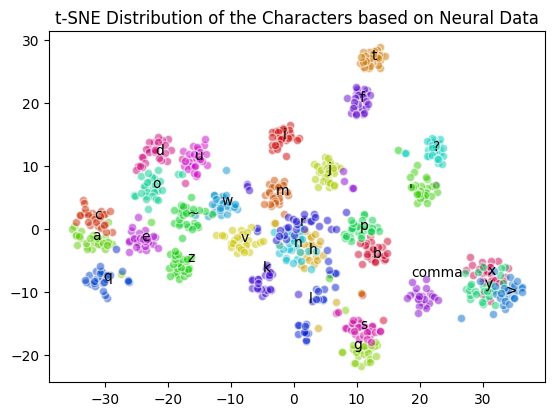

In [9]:
# Code from t-SNE analysis of Willett Dataset Google Collab Notebook
low_d_transform = data.reshape((837, 142, 192), order='F')[:, :, :15].reshape((837, -1), order='F')
print(low_d_transform.shape)
df = tsne_analysis(low_d_transform, label, distance_metric=warping_distance_metric)

In [10]:
# Dataset of Neural Data and Label
df

,x,y,label
0,-34.812634,0.450893,a
1,-35.256699,-0.055217,a
2,-33.717552,-0.374726,a
3,-33.859184,-1.380313,a
4,-32.807030,-2.686005,a
...,...,...,...
832,21.969641,11.740675,?
833,23.678484,11.548302,?
834,22.711880,11.098826,?
835,23.506693,10.397835,?


## Clustering Algorithm for All Characters

In [11]:
# Dataset of Neural Data and Labels
df

,x,y,label
0,-34.812634,0.450893,a
1,-35.256699,-0.055217,a
2,-33.717552,-0.374726,a
3,-33.859184,-1.380313,a
4,-32.807030,-2.686005,a
...,...,...,...
832,21.969641,11.740675,?
833,23.678484,11.548302,?
834,22.711880,11.098826,?
835,23.506693,10.397835,?


In [80]:
coordinates = df[['x', 'y']].to_numpy()
labels_1 = df[['label']].to_numpy()

In [13]:
# KMeans import
from sklearn.cluster import KMeans

In [14]:
# Coding KMeans
kmeans = KMeans(n_clusters = 31, random_state = 0, n_init = 'auto').fit(coordinates)
kmeans.labels_

array([28, 28, 28, 28, 28, 28, 28, 28, 28, 11, 28, 28, 11, 11, 11, 28, 11,
       28, 11, 11, 29, 11, 11, 11, 11, 11, 11, 27, 26, 26, 27, 27, 27, 27,
       27, 27, 27, 27, 27, 10, 27, 27,  6, 27, 27, 27, 27, 10, 27, 27, 27,
       27, 27, 27, 29, 29, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 11, 11, 29, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 13, 20, 20, 20, 20, 20, 20,
       20, 20, 20,  3, 13, 20, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  6,  6,  6,  6,  6,  6,  6,  6,
       26,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        9,  6, 18, 26, 12, 12, 26, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       25, 25, 12, 12, 12, 25, 25, 25, 12, 25, 21, 21, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [81]:
len(coordinates) == len(kmeans.labels_) #check that each neural data (x, y) has a label from KMeans
kmeans_lab = pd.DataFrame(kmeans.labels_, columns=['clusters']) #dataframe of the labels KMeans generated
labels_df = pd.DataFrame(labels_1, columns=['labels']) #dataframe of the labels from df

In [84]:
# Creating new dataframe with neural data, cluster label, and true label
clusters_df = pd.DataFrame(coordinates)
clusters_df = pd.concat([clusters_df, kmeans_lab], axis=1)
clusters_df = pd.concat([clusters_df, labels_df], axis=1)

In [85]:
# Renaming the columns of clusters_df
clusters_df.rename(columns = {0:'x', 1:'y', 'labels':'label'}, inplace=True)
clusters_df

,x,y,clusters,label
0,-34.812634,0.450893,28,a
1,-35.256699,-0.055217,28,a
2,-33.717552,-0.374726,28,a
3,-33.859184,-1.380313,28,a
4,-32.807030,-2.686005,28,a
...,...,...,...,...
832,21.969641,11.740675,8,?
833,23.678484,11.548302,8,?
834,22.711880,11.098826,8,?
835,23.506693,10.397835,8,?


In [86]:
# Edited previous helper functions to work for
def plot_tsne_results_clusters(df):
    """
    Function to plot the t-SNE results
    """

    colors = [[0.3613, 0.8000,  0], [0.8000,  0, 0.1548], \
              [0.8000, 0.1548,  0], [0.8000,  0, 0.4645], \
              [0.6710,  0, 0.8000], [0.3613,  0, 0.8000], \
              [0.5161, 0.8000,  0], [0.8000, 0.6194,  0], \
              [0.8000,  0,  0], [0.6710, 0.8000,  0], \
              [0.2065,  0, 0.8000],  [0, 0.1032, 0.8000], \
              [0.8000, 0.3097,  0],  [0, 0.7226, 0.8000], \
              [0, 0.8000, 0.5677],  [0, 0.8000, 0.2581], \
              [0, 0.2581, 0.8000], [0.0516,  0, 0.8000], \
              [0.8000,  0, 0.6194], [0.8000, 0.4645,  0], \
              [0.8000,  0, 0.7742], [0.8000, 0.7742,  0], \
              [0, 0.5677, 0.8000], [0.8000,  0, 0.3097], \
              [0, 0.8000, 0.4129], [0.0516, 0.8000,  0], \
              [0, 0.4129, 0.8000], [0.5161,  0, 0.8000], \
              [0.2065, 0.8000,  0],  [0, 0.8000, 0.1032], \
              [0, 0.8000, 0.7226]]
    colors = np.array(colors)

    # Maping from the colors to the labels
    color_dict_mapping = {}
    unique_labels = df['clusters'].unique()
    for idx in range(len(unique_labels)):
        color_dict_mapping[unique_labels[idx]] = colors[idx, :]

    # Plot away
    ax = plt.axes()
    for idx,clue in enumerate(unique_labels):
        ax.scatter(df[df["clusters"]==clue]["x"], df[df["clusters"]==clue]["y"], \
                   c=colors[idx], alpha=0.5, label=str(clue), edgecolor="white")

    # plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", ncols=2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title("t-SNE Distribution of the Characters based on Neural Data")
    ax.set_xlabel("")
    ax.set_ylabel("")
    label_points_clusters(ax, df, unique_labels)


In [87]:
def label_points_clusters(ax, df, unique_labels):
    a = pd.DataFrame()
    for i in unique_labels:
        a = pd.concat([a, pd.DataFrame({"x": [df[df["clusters"] == i]["x"].mean()], \
                      "y": [df[df["clusters"] == i]["y"].mean()], \
                      "val": [i]})], ignore_index=True)

    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

    plt.show()

<ipython-input-86-9eac07a23692>:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["clusters"]==clue]["x"], df[df["clusters"]==clue]["y"], \


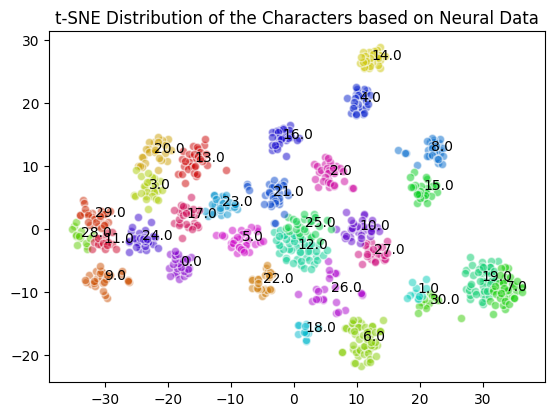

In [88]:
plot_tsne_results_clusters(clusters_df)

<ipython-input-90-7303f8d11749>:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(clusters_df[clusters_df["label"]==clue]["x"], clusters_df[clusters_df["label"]==clue]["y"], \


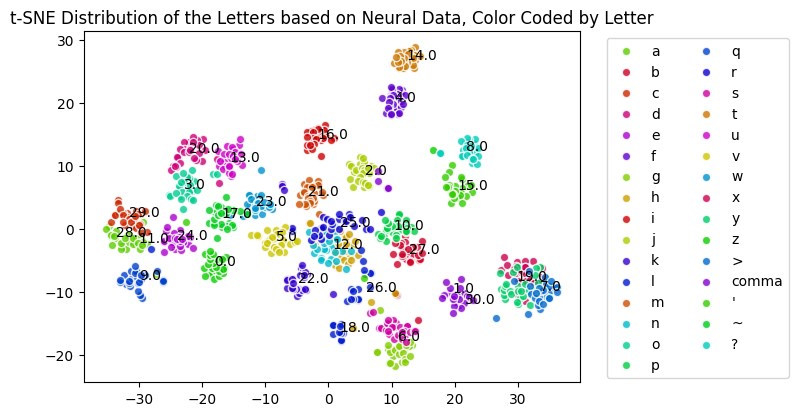

In [90]:
# Making t-SNE graph for clustered data from KMeans from helper function above
# Dots are color coded by their true label within their clusters
colors = [[0.3613, 0.8000,  0], [0.8000,  0, 0.1548], \
          [0.8000, 0.1548,  0], [0.8000,  0, 0.4645], \
          [0.6710,  0, 0.8000], [0.3613,  0, 0.8000], \
          [0.5161, 0.8000,  0], [0.8000, 0.6194,  0], \
          [0.8000,  0,  0], [0.6710, 0.8000,  0], \
          [0.2065,  0, 0.8000],  [0, 0.1032, 0.8000], \
          [0.8000, 0.3097,  0],  [0, 0.7226, 0.8000], \
          [0, 0.8000, 0.5677],  [0, 0.8000, 0.2581], \
          [0, 0.2581, 0.8000], [0.0516,  0, 0.8000], \
          [0.8000,  0, 0.6194], [0.8000, 0.4645,  0], \
          [0.8000,  0, 0.7742], [0.8000, 0.7742,  0], \
          [0, 0.5677, 0.8000], [0.8000,  0, 0.3097], \
          [0, 0.8000, 0.4129], [0.0516, 0.8000,  0], \
          [0, 0.4129, 0.8000], [0.5161,  0, 0.8000], \
          [0.2065, 0.8000,  0],  [0, 0.8000, 0.1032], \
          [0, 0.8000, 0.7226]]
colors = np.array(colors)

# Maping from the colors to the labels
color_dict_mapping = {}
unique_labels = clusters_df['clusters'].unique()
color_labels = clusters_df['label'].unique()
for idx in range(len(color_labels)):
    color_dict_mapping[color_labels[idx]] = colors[idx, :]

# Plot away
ax = plt.axes()
for idx,clue in enumerate(color_labels):
    ax.scatter(clusters_df[clusters_df["label"]==clue]["x"], clusters_df[clusters_df["label"]==clue]["y"], \
                c=colors[idx], alpha=0.8, label=str(clue), edgecolor="white")


plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", ncols=2)

ax.set_aspect('equal', adjustable='box')
ax.set_title("t-SNE Distribution of the Letters based on Neural Data, Color Coded by Letter")
ax.set_xlabel("")
ax.set_ylabel("")
label_points_clusters(ax, clusters_df, unique_labels)

In [91]:
clusters_df

,x,y,clusters,label
0,-34.812634,0.450893,28,a
1,-35.256699,-0.055217,28,a
2,-33.717552,-0.374726,28,a
3,-33.859184,-1.380313,28,a
4,-32.807030,-2.686005,28,a
...,...,...,...,...
832,21.969641,11.740675,8,?
833,23.678484,11.548302,8,?
834,22.711880,11.098826,8,?
835,23.506693,10.397835,8,?


<ipython-input-7-bff676e14180>:72: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(df[df["label"]==char]["x"], df[df["label"]==char]["y"], \


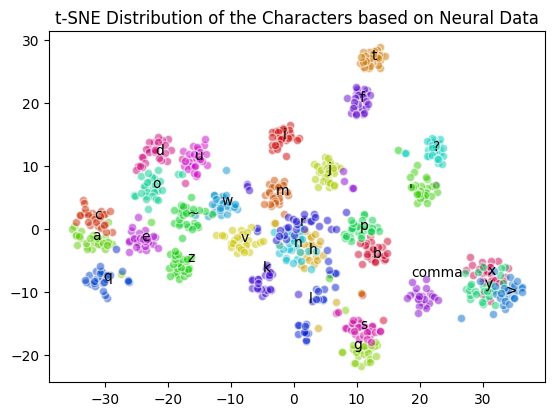

In [92]:
# t-SNE graph from Willett Dataset Collab
plot_tsne_results(clusters_df)

In [93]:
df

,x,y,label
0,-34.812634,0.450893,a
1,-35.256699,-0.055217,a
2,-33.717552,-0.374726,a
3,-33.859184,-1.380313,a
4,-32.807030,-2.686005,a
...,...,...,...
832,21.969641,11.740675,?
833,23.678484,11.548302,?
834,22.711880,11.098826,?
835,23.506693,10.397835,?


In [94]:
# Grouping to see Frequency of Each Letter in Each Cluster
heatmap_data = clusters_df.copy()
heatmap_data['count'] = 1
heatmap_data_grouped = heatmap_data.groupby(['clusters']).apply(lambda df: df[['label', 'count']].groupby('label').count().transpose())
heatmap_data_grouped

,label,z,comma,j,d,o,f,r,v,b,g,...,h,n,u,w,t,i,~,k,m,e
clusters,,,,,,,,,,,,,,,,,,,,,,
0,count,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,count,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,count,NaN,4.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,count,NaN,NaN,NaN,1.0,24.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,count,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,count,NaN,NaN,NaN,NaN,NaN,NaN,2.0,27.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,25.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,count,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
corr_smth = heatmap_data_grouped.reset_index().drop(columns=['level_1']).set_index('clusters')

In [96]:
# Finding the Most Common Letter in Each Cluster = What Each Cluster's Letter is
(corr_smth/(corr_smth.sum(axis=1).sum())).idxmax(axis=1)

clusters
0         z
1     comma
2         j
3         o
4         f
5         v
6         g
7         >
8         ?
9         q
10        p
11        a
12        n
13        u
14        t
15        '
16        i
17        ~
18        l
19        x
20        d
21        m
22        k
23        w
24        e
25        r
26        l
27        b
28        a
29        c
30    comma
dtype: object

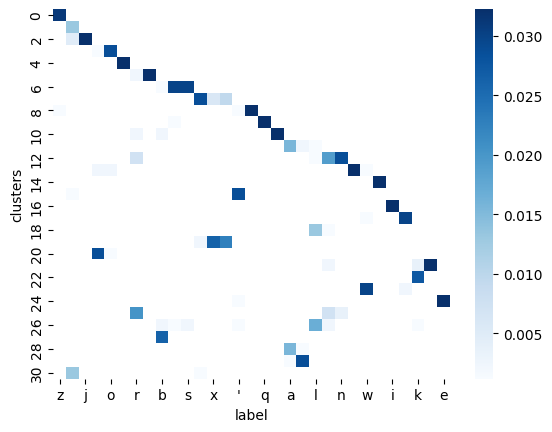

In [97]:
# Coding the Confusion Matrix without Annotation
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(corr_smth/(corr_smth.sum(axis=1).sum()), cmap = 'Blues', annot = False)
plt.show()

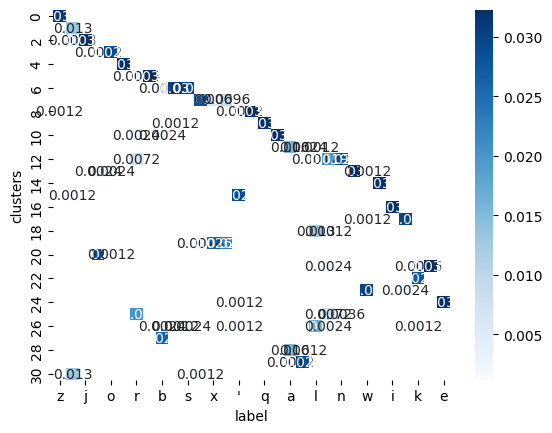

In [98]:
# Confusion Matrix of Normalized Data
import seaborn as sns
from sklearn.metrics import confusion_matrix
#cf_matrix = confusion_matrix()
sns.heatmap(corr_smth/(corr_smth.sum(axis=1).sum()), cmap = 'Blues', annot = True)
plt.show()

In [99]:
# Finding the Most Common Letter in Each Cluster = What Each Cluster's Letter is and formatting it to a dictionary
letter_assignment = ((corr_smth/(corr_smth.sum(axis=1).sum())).idxmax(axis=1)).to_dict()
letter_assignment

{0: 'z',
 1: 'comma',
 2: 'j',
 3: 'o',
 4: 'f',
 5: 'v',
 6: 'g',
 7: '>',
 8: '?',
 9: 'q',
 10: 'p',
 11: 'a',
 12: 'n',
 13: 'u',
 14: 't',
 15: "'",
 16: 'i',
 17: '~',
 18: 'l',
 19: 'x',
 20: 'd',
 21: 'm',
 22: 'k',
 23: 'w',
 24: 'e',
 25: 'r',
 26: 'l',
 27: 'b',
 28: 'a',
 29: 'c',
 30: 'comma'}

In [100]:
# Making prediction column for their classification based on clustering from KMeans
clusters_df['predicted'] = clusters_df['clusters'].replace(letter_assignment)

In [101]:
(clusters_df['label'] == clusters_df['predicted'])

0      True
1      True
2      True
3      True
4      True
       ... 
832    True
833    True
834    True
835    True
836    True
Length: 837, dtype: bool

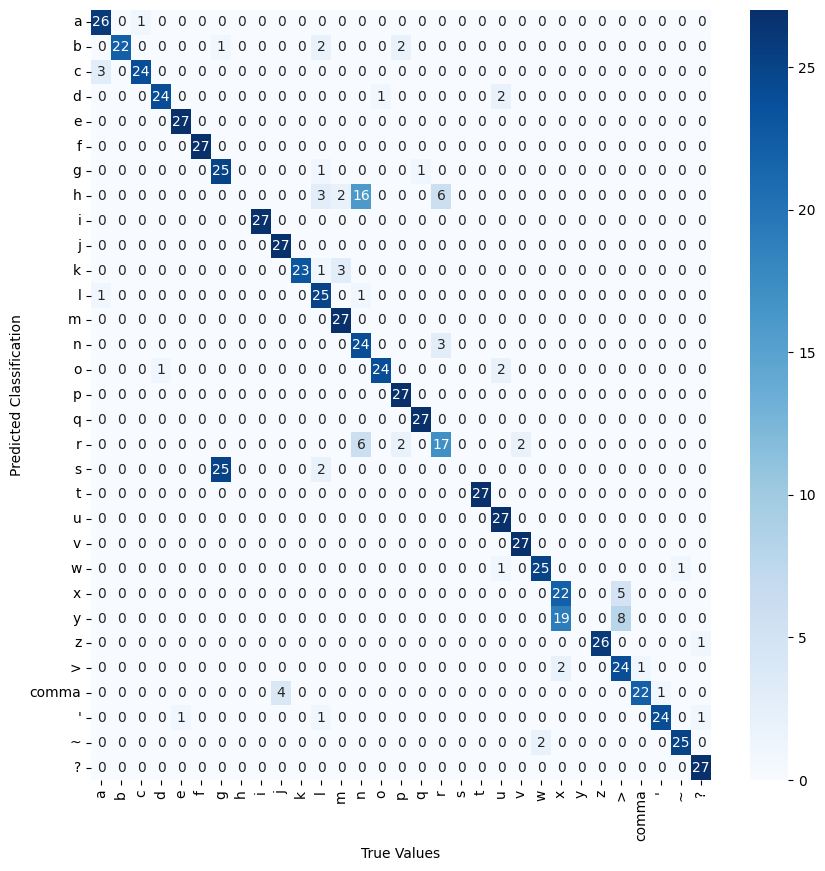

In [102]:
# Plotting Confusion Matrix
plt.figure(figsize = (10, 10))
actual_matrix = confusion_matrix(clusters_df['label'], clusters_df['predicted'], labels=clusters_df['label'].unique())
sns.heatmap(actual_matrix, cmap = 'Blues', annot = True, xticklabels=clusters_df['label'].unique(), yticklabels=clusters_df['label'].unique())
plt.xlabel('Predicted Classification')
plt.ylabel('True Values')
plt.title('')
plt.show()

In [103]:
clusters_df['label'].unique()

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
       '>', 'comma', "'", '~', '?'], dtype=object)

## Clustering Algorithm for Certain Letters

In [ ]:
# n_mask = df['label'] != 'n'
# removed_n = df[n_mask]

# removed_n.shape

(810, 3)

In [48]:
# Choosing characters that were group closer and those far apart in the t-SNE graph
df_2 = df[df['label'].isin(['i', 'j', 'p', 'b', 'm', 'r', 'n', 'h', 'l', 'k', 'v', 't'])]
coordinates_2 = df_2[['x', 'y']].to_numpy()
labels_2 = df_2[['label']].to_numpy()
df_2

,x,y,label
27,10.858193,-5.556908,b
28,10.903996,-10.480578,b
29,10.792289,-10.362807,b
30,13.867690,-4.442047,b
31,13.269063,-3.893956,b
...,...,...,...
589,-9.750719,-0.077617,v
590,-8.345037,-3.124366,v
591,-7.827096,-3.593939,v
592,-5.395207,-1.985075,v


In [58]:
# Coding the KMeans Clustering Algorithm
kmeans_2 = KMeans(n_clusters = 12, random_state = 0, n_init = 'auto').fit(coordinates_2)
kmeans_2.labels_

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,  1, 11,  1, 11, 11,
        1, 11,  1,  1, 11, 11, 11, 11, 11, 11,  6, 11,  8,  8,  6,  8,  8,
        8,  8,  8,  8,  8,  8,  3,  8,  3,  3,  8,  3,  3,  3,  3,  8,  8,
        3,  3,  3,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  0,  4,  0,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  6,  6,
       10,  6,  8,  6,  8,  8,  8,  8,  6,  6,  6,  8,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,
        0,  0,  8,  8,  3,  8,  3,  8,  8,  8,  8,  8,  8,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [59]:
# Making separate dataframes for the predicted labels and actual labels
len(coordinates) == len(kmeans_2.labels_) #check that each neural data (x, y) has a label from KMeans
kmeans_lab_2 = pd.DataFrame(kmeans_2.labels_, columns=['clusters']) #dataframe of the labels KMeans generated
labels_df_2 = pd.DataFrame(labels_2, columns=['labels']) #dataframe of the labels from df_2
labels_df_2

,labels
0,b
1,b
2,b
3,b
4,b
...,...
319,v
320,v
321,v
322,v


In [62]:
# Creating new dataframe with neural data, cluster label, and true label
clusters_df_2 = pd.DataFrame(coordinates_2)
clusters_df_2 = pd.concat([clusters_df_2, kmeans_lab_2], axis=1)
clusters_df_2 = pd.concat([clusters_df_2, labels_df_2], axis=1)
clusters_df_2

,0,1,clusters,labels
0,10.858193,-5.556908,11,b
1,10.903996,-10.480578,11,b
2,10.792289,-10.362807,11,b
3,13.867690,-4.442047,11,b
4,13.269063,-3.893956,11,b
...,...,...,...,...
319,-9.750719,-0.077617,7,v
320,-8.345037,-3.124366,7,v
321,-7.827096,-3.593939,7,v
322,-5.395207,-1.985075,7,v


In [64]:
# Renaming the columns of clusters_df
clusters_df_2.rename(columns = {0:'x', 1:'y', 'labels':'label'}, inplace=True)
clusters_df_2

,x,y,clusters,label
0,10.858193,-5.556908,11,b
1,10.903996,-10.480578,11,b
2,10.792289,-10.362807,11,b
3,13.867690,-4.442047,11,b
4,13.269063,-3.893956,11,b
...,...,...,...,...
319,-9.750719,-0.077617,7,v
320,-8.345037,-3.124366,7,v
321,-7.827096,-3.593939,7,v
322,-5.395207,-1.985075,7,v


<ipython-input-67-78b5df201dfe>:29: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(clusters_df_2[clusters_df_2["label"]==clue]["x"], clusters_df_2[clusters_df_2["label"]==clue]["y"], \


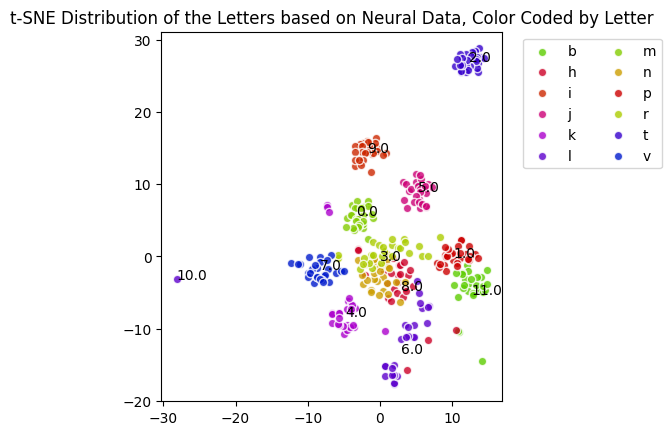

In [67]:
# Plotting the t-SNE Graph Analysis with each cluster's dot labeled with their true label
colors = [[0.3613, 0.8000,  0], [0.8000,  0, 0.1548], \
          [0.8000, 0.1548,  0], [0.8000,  0, 0.4645], \
          [0.6710,  0, 0.8000], [0.3613,  0, 0.8000], \
          [0.5161, 0.8000,  0], [0.8000, 0.6194,  0], \
          [0.8000,  0,  0], [0.6710, 0.8000,  0], \
          [0.2065,  0, 0.8000],  [0, 0.1032, 0.8000], \
          [0.8000, 0.3097,  0],  [0, 0.7226, 0.8000], \
          [0, 0.8000, 0.5677],  [0, 0.8000, 0.2581], \
          [0, 0.2581, 0.8000], [0.0516,  0, 0.8000], \
          [0.8000,  0, 0.6194], [0.8000, 0.4645,  0], \
          [0.8000,  0, 0.7742], [0.8000, 0.7742,  0], \
          [0, 0.5677, 0.8000], [0.8000,  0, 0.3097], \
          [0, 0.8000, 0.4129], [0.0516, 0.8000,  0], \
          [0, 0.4129, 0.8000], [0.5161,  0, 0.8000], \
          [0.2065, 0.8000,  0],  [0, 0.8000, 0.1032], \
          [0, 0.8000, 0.7226]]
colors = np.array(colors)

# Maping from the colors to the labels
color_dict_mapping = {}
unique_labels = clusters_df_2['clusters'].unique()
color_labels = clusters_df_2['label'].unique()
for idx in range(len(color_labels)):
    color_dict_mapping[color_labels[idx]] = colors[idx, :]

# Plot away
ax = plt.axes()
for idx,clue in enumerate(color_labels):
    ax.scatter(clusters_df_2[clusters_df_2["label"]==clue]["x"], clusters_df_2[clusters_df_2["label"]==clue]["y"], \
                c=colors[idx], alpha=0.8, label=str(clue), edgecolor="white")


plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", ncols=2)

ax.set_aspect('equal', adjustable='box')
ax.set_title("t-SNE Distribution of the Letters based on Neural Data, Color Coded by Letter")
ax.set_xlabel("")
ax.set_ylabel("")
label_points_clusters(ax, clusters_df_2, unique_labels)

In [70]:
# Grouping to see Frequency of Each Letter in Each Cluster
heatmap_data_2 = clusters_df_2.copy()
heatmap_data_2['count'] = 1
heatmap_data_grouped_2 = heatmap_data_2.groupby(['clusters']).apply(lambda df: df[['label', 'count']].groupby('label').count().transpose())
heatmap_data_grouped_2

,label,k,m,b,p,r,t,h,n,j,l,v,i
clusters,,,,,,,,,,,,,
0,count,3.0,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,count,NaN,NaN,5.0,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,count,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN
3,count,NaN,1.0,NaN,NaN,21.0,NaN,10.0,18.0,NaN,NaN,NaN,NaN
4,count,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN
6,count,1.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,20.0,NaN,NaN
7,count,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,27.0,NaN
8,count,NaN,NaN,NaN,NaN,NaN,NaN,14.0,9.0,NaN,6.0,NaN,NaN


In [71]:
corr_smth_2 = heatmap_data_grouped_2.reset_index().drop(columns=['level_1']).set_index('clusters')

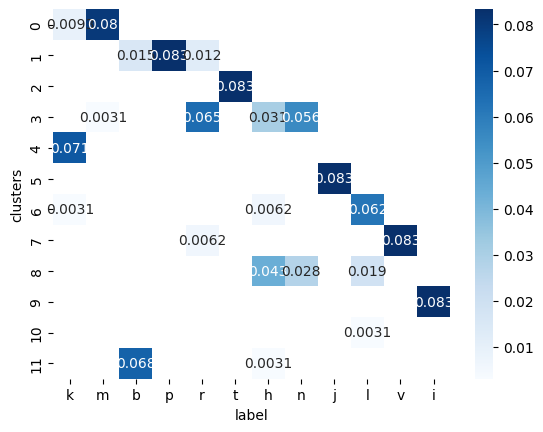

In [73]:
# Coding the Confusion Matrix with Annotation of Normalized Data
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(corr_smth_2/(corr_smth_2.sum(axis=1).sum()), cmap = 'Blues', annot = True)
plt.show()

In [74]:
# Finding the Most Common Letter in Each Cluster = What Each Cluster's Letter is and formatting it to a dictionary
letter_assignment = ((corr_smth_2/(corr_smth_2.sum(axis=1).sum())).idxmax(axis=1)).to_dict()
letter_assignment

{0: 'm',
 1: 'p',
 2: 't',
 3: 'r',
 4: 'k',
 5: 'j',
 6: 'l',
 7: 'v',
 8: 'h',
 9: 'i',
 10: 'l',
 11: 'b'}

In [76]:
# Making prediction column for their classification based on clustering from KMeans
clusters_df_2['predicted'] = clusters_df_2['clusters'].replace(letter_assignment)
clusters_df_2

,x,y,clusters,label,predicted
0,10.858193,-5.556908,11,b,b
1,10.903996,-10.480578,11,b,b
2,10.792289,-10.362807,11,b,b
3,13.867690,-4.442047,11,b,b
4,13.269063,-3.893956,11,b,b
...,...,...,...,...,...
319,-9.750719,-0.077617,7,v,v
320,-8.345037,-3.124366,7,v,v
321,-7.827096,-3.593939,7,v,v
322,-5.395207,-1.985075,7,v,v


In [78]:
(clusters_df_2['label'] == clusters_df_2['predicted'])

0      True
1      True
2      True
3      True
4      True
       ... 
319    True
320    True
321    True
322    True
323    True
Length: 324, dtype: bool

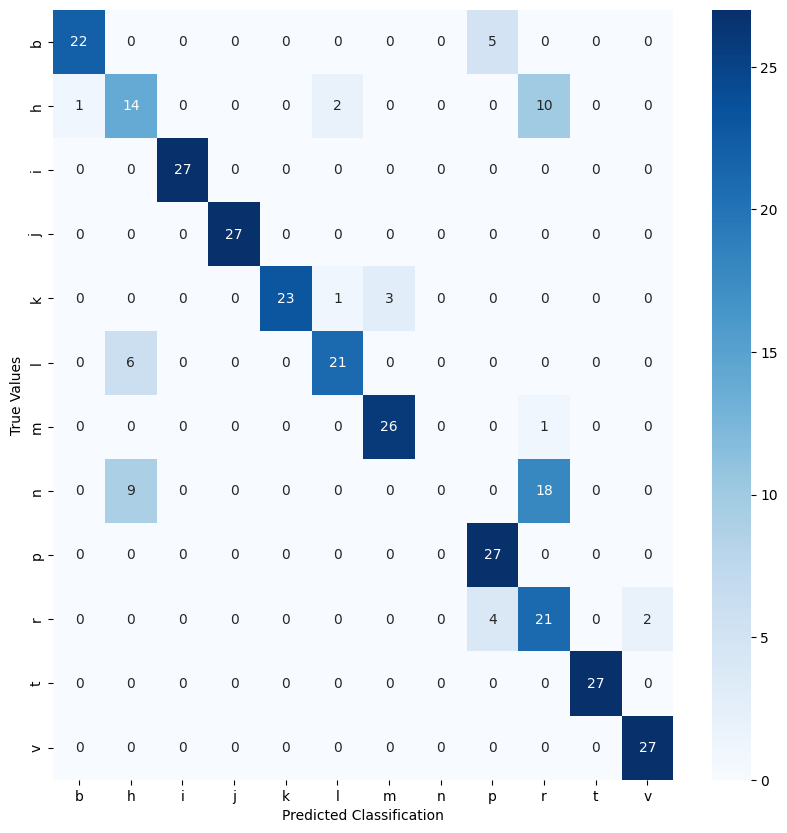

In [113]:
# Plotting Confusion Matrix
plt.figure(figsize = (10, 10))
actual_matrix_2 = confusion_matrix(clusters_df_2['label'], clusters_df_2['predicted'], labels=clusters_df_2['label'].unique())
sns.heatmap(actual_matrix_2, cmap = 'Blues', annot = True, xticklabels=clusters_df_2['label'].unique(), yticklabels=clusters_df_2['label'].unique())
plt.xlabel('Predicted Classification')
plt.ylabel('True Values')
plt.title('')
plt.show()

In [107]:
# Splitting the Data and Labels into Train and Test Data
# 20 data points for each letter into Train and 7 data points for each letter into test
print(data.shape, labels.shape)
labels
train_y = []
test_y = []
train_x = []
test_x = []
start = 0
for i in range(31):
  train_y = train_y + list(labels[start: start+20])
  test_y = test_y + list(labels[start+20: start+27])
  train_x = train_x + list(data[start: start+20])
  test_x = test_x + list(data[start+20: start+27])
  start += 27

(837, 27264) (837,)


In [108]:
# Coding the LDA Classifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(train_x, train_y)
predicted_y = clf.predict(test_x)

In [109]:
# Accuracy Score of the Model
clf.score(test_x, test_y)

0.6589861751152074

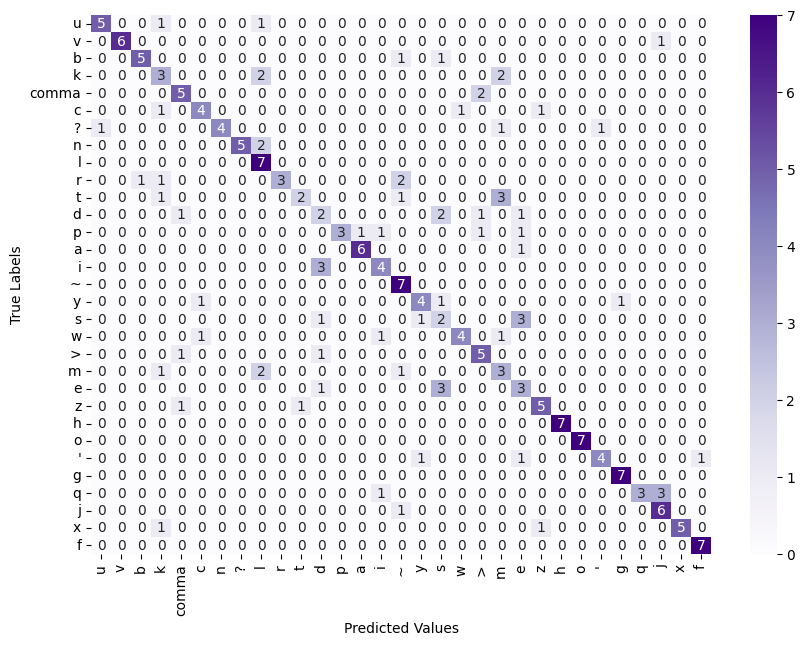

In [112]:
# Confusion Matrix of LDA
from sklearn.metrics import confusion_matrix
plt.figure(figsize = (10, 7))
confused = confusion_matrix(test_y, predicted_y)
sns.heatmap(confused, cmap = 'Purples', annot = True, xticklabels = list(set(test_y)), yticklabels = list(set(predicted_y)))
plt.xlabel('Predicted Values')
plt.ylabel('True Labels')
plt.show()